# Performance Comparison of Deep Learning Frameworks

## Image Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn import model_selection as ms
from sys import platform
import DLHelper

/Users/moderato/Downloads/GTSRB/try
Training Image preprocessing finished in 15.07 seconds
Testing Image preprocessing finished in 4.84 seconds
(48, 48, 3)


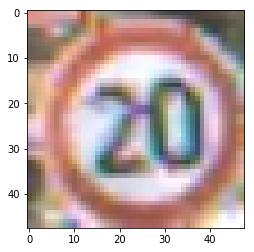

(48, 48, 3)


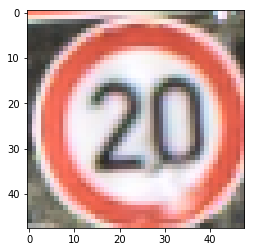

In [2]:
if platform == "darwin":
    root = "/Users/moderato/Downloads/GTSRB/try"
else:
    root = "/home/zhongyilin/Desktop/GTSRB/try"
print(root)
resize_size = (48, 48)
epoch_num = 25
batch_size = 64
trainImages, trainLabels, testImages, testLabels = DLHelper.getImageSets(root, resize_size, 'clahe')
x_train, x_valid, y_train, y_valid = ms.train_test_split(trainImages, trainLabels, test_size=0.2, random_state=542)

Training Image preprocessing finished in 6.79 seconds
Testing Image preprocessing finished in 2.01 seconds
(48, 48, 3)


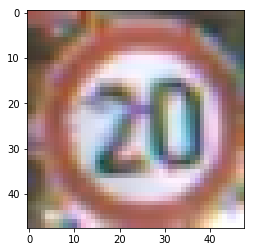

(48, 48, 3)


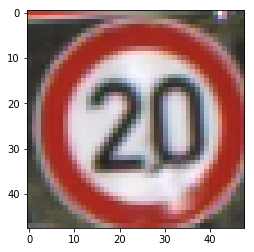

In [3]:
a,b,c,d = DLHelper.getImageSets(root, resize_size)

## Intel Nervana Neon

In [ ]:
from neon.backends import gen_backend, cleanup_backend
from neon.initializers import Gaussian, Constant, GlorotUniform
from neon.layers import GeneralizedCost, Affine
from neon.layers import Conv as neon_Conv, Dropout as neon_Dropout, Pooling as neon_Pooling
from neon.transforms import Rectlin, Softmax, CrossEntropyMulti, Misclassification, TopKMisclassification
from neon.models import Model
from neon.optimizers import GradientDescentMomentum as neon_SGD, RMSProp as neon_RMSProp, ExpSchedule
from neon.callbacks.callbacks import Callbacks, Callback, LossCallback
from neon.data.dataiterator import ArrayIterator
from timeit import default_timer

In [ ]:
class SelfCallback(LossCallback):
    def __init__(self, eval_set, epoch_freq):
        super(SelfCallback, self).__init__(eval_set=eval_set, epoch_freq=epoch_freq)
        self.train_batch_time = None
        self.total_batch_index = 0
        
    def on_train_begin(self, callback_data, model, epochs):
        super(SelfCallback, self).on_train_begin(callback_data, model, epochs)
        
        # Save training time per batch
        points = callback_data['config'].attrs['total_minibatches']
        tb = callback_data.create_dataset("time/train_batch", (points,))
        tb.attrs['time_markers'] = 'minibatch'
        
    def on_minibatch_begin(self, callback_data, model, epoch, minibatch):
        self.train_batch_time = default_timer()

    def on_minibatch_end(self, callback_data, model, epoch, minibatch):
        callback_data["time/train_batch"][self.total_batch_index] = (default_timer() - self.train_batch_time)
        self.total_batch_index += 1

In [ ]:
mlp = None
epoch_num = 50

neon_backends = ["cpu", "mkl", "gpu"]
neon_gaussInit = Gaussian(loc=0.0, scale=0.01)
d = dict()
neon_lr = {"cpu": 0.01, "mkl": 0.0005, "gpu": 0.01}
run_or_not = {"cpu": False, "mkl": True, "gpu": False}

cleanup_backend()

for b in neon_backends:
    if run_or_not[b]:
        print("Use {} as backend.".format(b))

        # Set up backend
        # backend: 'cpu' for single, 'mkl' for multi-thread cpu, and 'gpu' for gpu
        be = gen_backend(backend=b, batch_size=batch_size, rng_seed=542, datatype=np.float32)
        print(type(be))

        # Make iterators
        x_train, x_valid, neon_y_train, neon_y_valid = ms.train_test_split(trainImages, trainLabels, test_size=0.2, random_state=542)
        neon_train_set = ArrayIterator(X=np.asarray([t.flatten().astype('float32')/255 for t in x_train]), y=np.asarray(neon_y_train), make_onehot=True, nclass=43, lshape=(3, resize_size[0], resize_size[1]))
        neon_valid_set = ArrayIterator(X=np.asarray([t.flatten().astype('float32')/255 for t in x_valid]), y=np.asarray(neon_y_valid), make_onehot=True, nclass=43, lshape=(3, resize_size[0], resize_size[1]))
        neon_test_set = ArrayIterator(X=np.asarray([t.flatten().astype('float32')/255 for t in testImages]), y=np.asarray(testLabels), make_onehot=True, nclass=43, lshape=(3, resize_size[0], resize_size[1]))

        # Construct CNN
        layers = []
        layers.append(neon_Conv((5, 5, 64), strides=2, init=neon_gaussInit, bias=Constant(0.0), activation=Rectlin(), name="neon_conv1"))
        layers.append(neon_Pooling(2, op="max", strides=2, name="neon_pool1"))
        layers.append(neon_Conv((3, 3, 512), strides=1, padding=1, init=neon_gaussInit, bias=Constant(0.0), activation=Rectlin(), name="neon_conv2"))
        layers.append(neon_Pooling(2, op="max", strides=2, name="neon_pool2"))
    #     layers.append(neon_Pooling(5, op="avg", name="neon_global_pool"))
        layers.append(Affine(nout=2048, init=neon_gaussInit, bias=Constant(0.0), activation=Rectlin(), name="neon_fc1"))
        layers.append(neon_Dropout(keep=0.5, name="neon_drop_out"))
        layers.append(Affine(nout=43, init=neon_gaussInit, bias=Constant(0.0), activation=Softmax(), name="neon_fc2"))

        # Initialize model object
        mlp = Model(layers=layers)

        # Costs
        neon_cost = GeneralizedCost(costfunc=CrossEntropyMulti())

        # Model summary
        mlp.initialize(neon_train_set, neon_cost)
        #     print(mlp)

        # Learning rules

        neon_optimizer = neon_SGD(neon_lr[b], momentum_coef=0.9, schedule=ExpSchedule(0.2))
    #     neon_optimizer = neon_RMSProp(learning_rate=0.0001, decay_rate=0.95)

        # Benchmark for 20 minibatches
        d[b] = mlp.benchmark(neon_train_set, cost=neon_cost, optimizer=neon_optimizer)

        # Reset model
        mlp = None
        mlp = Model(layers=layers)
        mlp.initialize(neon_train_set, neon_cost)

        # Callbacks: validate on validation set
        callbacks = Callbacks(mlp, eval_set=neon_valid_set, metric=Misclassification(3), output_file=root+"/callback_data_{}.h5".format(b))
        callbacks.add_callback(SelfCallback(eval_set=neon_valid_set, epoch_freq=1))

        # Fit
        start = time.time()
        mlp.fit(neon_train_set, optimizer=neon_optimizer, num_epochs=epoch_num, cost=neon_cost, callbacks=callbacks)
        print("Neon training finishes in {:.2f} seconds.".format(time.time() - start))

        # Result
        results = mlp.get_outputs(neon_valid_set)

        # Print error on validation set
        start = time.time()
        neon_error_mis = mlp.eval(neon_valid_set, metric=Misclassification())*100
        print('Misclassification error = {:.1f}%. Finished in {:.2f} seconds.'.format(neon_error_mis[0], time.time() - start))

        start = time.time()
        neon_error_top3 = mlp.eval(neon_valid_set, metric=TopKMisclassification(3))*100
        print('Top 3 Misclassification error = {:.1f}%. Finished in {:.2f} seconds.'.format(neon_error_top3[2], time.time() - start))

        start = time.time()
        neon_error_top5 = mlp.eval(neon_valid_set, metric=TopKMisclassification(5))*100
        print('Top 5 Misclassification error = {:.1f}%. Finished in {:.2f} seconds.'.format(neon_error_top5[2], time.time() - start))

        mlp.save_params(root + "/saved_models/neon_weights_{}.prm".format(b))

        # Print error on test set
        start = time.time()
        neon_error_mis_t = mlp.eval(neon_test_set, metric=Misclassification())*100
        print('Misclassification error = {:.1f}% on test set. Finished in {:.2f} seconds.'.format(neon_error_mis_t[0], time.time() - start))

        start = time.time()
        neon_error_top3_t = mlp.eval(neon_test_set, metric=TopKMisclassification(3))*100
        print('Top 3 Misclassification error = {:.1f}% on test set. Finished in {:.2f} seconds.'.format(neon_error_top3_t[2], time.time() - start))

        start = time.time()
        neon_error_top5_t = mlp.eval(neon_test_set, metric=TopKMisclassification(5))*100
        print('Top 5 Misclassification error = {:.1f}% on test set. Finished in {:.2f} seconds.'.format(neon_error_top5_t[2], time.time() - start))

        cleanup_backend()
        mlp = None
        print("\n")

In [ ]:
# Draw figures
import h5py
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from neon.visualizations.data import h5_cost_data
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,8)

train_cost_batch = pd.DataFrame()
valid_cost_epoch = pd.DataFrame()
train_epoch_mark = dict()
# neon_backends = ["mkl", "cpu", "gpu"]

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
fig2, ax2 = plt.subplots(1, len(neon_backends))
markers = ['o', 'x', 'p']

for i in range(len(neon_backends)):
    b = neon_backends[i]
    
    f = h5py.File(root+"/callback_data_{}.h5".format(b), "r")
    keys = list(f['.'].keys())
    
    train_cost_batch['neon_{}_loss'.format(b)] = pd.Series(f['.']['cost']['train'][()])
    train_cost_batch['neon_{}_t'.format(b)] = pd.Series(f['.']['time']['train_batch'][()]).cumsum()
    
    valid_cost_epoch['neon_{}_loss'.format(b)] = pd.Series(f['.']['cost']['loss'][()])
    valid_cost_epoch['neon_{}_t'.format(b)] = pd.Series(f['.']['time']['loss'][()])
    
    tmp = (f['.']['time_markers']['minibatch'][()]-1).astype(int).tolist()
    tmp.pop()
    tmp = [0] + tmp
    train_epoch_mark['neon_{}_mark'.format(b)] = tmp
    
    ax1.plot(train_cost_batch['neon_{}_t'.format(b)].iloc[train_epoch_mark['neon_{}_mark'.format(b)]], \
             train_cost_batch['neon_{}_loss'.format(b)].iloc[train_epoch_mark['neon_{}_mark'.format(b)]], marker=markers[i])
    
    ax2[i].plot(range(len(train_epoch_mark['neon_{}_mark'.format(b)])), \
             train_cost_batch['neon_{}_loss'.format(b)].iloc[train_epoch_mark['neon_{}_mark'.format(b)]], marker=markers[0])
    ax2[i].plot(range(len(train_epoch_mark['neon_{}_mark'.format(b)])), valid_cost_epoch['neon_{}_loss'.format(b)], marker=markers[1])
    ax2[i].legend(loc='best')
    
    f.close()
    
ax1.legend(loc='best')
plt.show()
fig1.savefig(root+"/pics/neon_train_loss_time.png", dpi=fig1.dpi)
fig2.savefig(root+"/pics/neon_train_loss_epoch.png", dpi=fig2.dpi)

## Keras with different multiple backends (Tensorflow, Theano, CNTK)

In [3]:
from keras.layers import Conv2D as keras_Conv
from keras.layers import MaxPooling2D as keras_MaxPooling, GlobalAveragePooling2D as keras_AveragePooling
from keras.layers import Dropout as keras_Dropout, Dense, Flatten
from keras.models import Sequential
from keras.utils import np_utils, to_categorical
from keras import backend as K
from keras.preprocessing import image
from keras.initializers import RandomNormal, Constant as keras_Constant
from keras.optimizers import SGD as keras_SGD, RMSprop as keras_RMSProp
from keras.callbacks import ModelCheckpoint, Callback as keras_callback
from sklearn import model_selection as ms
from sklearn.preprocessing import OneHotEncoder
from keras.layers.convolutional import ZeroPadding2D
import os, h5py
from timeit import default_timer

Using TensorFlow backend.


In [14]:
class LossHistory(keras_callback):
    def __init__(self, filename, epoch_num, max_total_batch):
        super(keras_callback, self).__init__()
        
        self.batch_count = 0
        self.epoch_num = epoch_num
        self.filename = filename
        self.batch_time = None
        self.max_total_batch = max_total_batch
        
        self.f = h5py.File(filename, 'w')
        
        try:
            config = self.f.create_group('config')
            config.attrs["total_epochs"] = self.epoch_num

            cost = self.f.create_group('cost')
            loss = cost.create_dataset('loss', (self.epoch_num,))
            loss.attrs['time_markers'] = 'epoch_freq'
            loss.attrs['epoch_freq'] = 1
            train = cost.create_dataset('train', (self.max_total_batch,)) # Set size to maximum theoretical value
            train.attrs['time_markers'] = 'minibatch'

            t = self.f.create_group('time')
            loss = t.create_dataset('loss', (self.epoch_num,))
            train = t.create_group('train')
            start_time = train.create_dataset("start_time", (1,))
            start_time.attrs['units'] = 'seconds'
            end_time = train.create_dataset("end_time", (1,))
            end_time.attrs['units'] = 'seconds'
            train_batch = t.create_dataset('train_batch', (self.max_total_batch,)) # Same as above

            time_markers = self.f.create_group('time_markers')
            time_markers.attrs['epochs_complete'] = self.epoch_num
            train_batch = time_markers.create_dataset('minibatch', (self.epoch_num,))
        except Exception as e:
            self.f.close() # Avoid hdf5 runtime error or os error
            raise e # Catch the exception to close the file, then raise it to stop the program
    
    def on_train_begin(self, logs={}):
        try:
            self.f['.']['time']['train']['start_time'][0] = default_timer()
        except Exception as e:
            self.f.close()
            raise e

    def on_epoch_end(self, epoch, logs={}):
        try:
            self.f['.']['cost']['loss'][epoch] = np.float32(logs.get('val_loss'))
            self.f['.']['time_markers']['minibatch'][epoch] = np.float32(self.batch_count)
        except Exception as e:
            self.f.close()
            raise e
        
    def on_batch_begin(self, batch, logs={}):
        try:
            self.batch_time = default_timer()
        except Exception as e:
            self.f.close()
            raise e
    
    def on_batch_end(self, batch, logs={}):
        try:
            self.f['.']['cost']['train'][self.batch_count] = np.float32(logs.get('loss'))
            self.f['.']['time']['train_batch'][self.batch_count] = (default_timer() - self.batch_time)
            self.batch_count += 1
        except Exception as e:
            self.f.close()
            raise e
        
    def on_train_end(self, logs=None):
        try:
            self.f['.']['time']['train']['end_time'][0] = default_timer()
            self.f['.']['config'].attrs["total_minibatches"] = self.batch_count
            self.f['.']['time_markers'].attrs['minibatches_complete'] = self.batch_count
            self.f.close()
        except Exception as e:
            self.f.close()
            raise e

In [11]:
# Function to dynamically change keras backend
from importlib import reload
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

In [15]:
from sys import platform
backends = ["tensorflow", "theano"]
if platform != "darwin":
    backends.append("cntk")

for b in backends:
    set_keras_backend(b)
    
    max_total_batch = (len(x_train) / batch_size + 1) * epoch_num
    
    # Load and process images
    enc = OneHotEncoder(sparse=False)
    keras_train_x = np.vstack([np.expand_dims(image.img_to_array(x), axis=0).astype('float32')/255 for x in x_train])
    keras_valid_x = np.vstack([np.expand_dims(image.img_to_array(x), axis=0).astype('float32')/255 for x in x_valid])
    keras_test_x = np.vstack([np.expand_dims(image.img_to_array(x), axis=0).astype('float32')/255 for x in testImages])
    keras_train_y = to_categorical(y_train, 43)
    keras_valid_y = to_categorical(y_valid, 43)
    keras_test_y = to_categorical(testLabels, 43)

    # Build model
    keras_gaussInit = RandomNormal(mean=0.0, stddev=0.01, seed=542)
    layer_name_prefix = b+"_"

    keras_model = Sequential()
    keras_model.add(keras_Conv(64, (5, 5), kernel_initializer=keras_gaussInit, strides=(2, 2), bias_initializer=keras_Constant(0.0), activation="relu", input_shape=(resize_size[0], resize_size[1], 3), name=layer_name_prefix+"conv1"))
    keras_model.add(keras_MaxPooling(pool_size=(2, 2), name=layer_name_prefix+"pool1"))
    keras_model.add(keras_Conv(256, (3, 3), kernel_initializer=keras_gaussInit, strides=(1, 1), padding="same", bias_initializer=keras_Constant(0.0), activation="relu", name=layer_name_prefix+"conv2"))
    keras_model.add(keras_MaxPooling(pool_size=(2, 2), name=layer_name_prefix+"pool2"))
    keras_model.add(keras_AveragePooling(name=layer_name_prefix+"global_pool"))
#     keras_model.add(Flatten(name=layer_name_prefix+"flatten")) # An extra layer to flatten the previous layer in order to connect to fully connected layer
#     keras_model.add(Dense(4096, kernel_initializer=keras_gaussInit, bias_initializer=keras_Constant(0.0), activation="relu", name=layer_name_prefix+"fc1"))
    keras_model.add(keras_Dropout(0.5, name=layer_name_prefix+"drop_out"))
    keras_model.add(Dense(43, kernel_initializer=keras_gaussInit, bias_initializer=keras_Constant(0.0), activation="softmax", name=layer_name_prefix+"fc2"))
    keras_model.summary()

    keras_optimizer = keras_SGD(lr=0.01, decay=1.6e-8, momentum=0.9) # Equivalent to decay rate 0.2 per epoch? Need to re-verify
#     keras_optimizer = keras_RMSProp(lr=0.01, decay=0.95)
    keras_cost = "categorical_crossentropy"
    keras_model.compile(loss=keras_cost, optimizer=keras_optimizer, metrics=["acc"])

    checkpointer = ModelCheckpoint(filepath=root+"/saved_models/keras_"+b+"_weights.hdf5",
                                       verbose=1, save_best_only=True)
    losses = LossHistory(root+"/callback_data_{}.h5".format(b), epoch_num, max_total_batch)

    start = time.time()
    keras_model.fit(keras_train_x, keras_train_y,
                  validation_data=(keras_valid_x, keras_valid_y),
                  epochs=epoch_num, batch_size=batch_size, callbacks=[checkpointer, losses], verbose=1, shuffle=True)
    print("{} training finishes in {:.2f} seconds.".format(b, time.time() - start))

    keras_model.load_weights(root+"/saved_models/keras_"+b+"_weights.hdf5")
    keras_predictions = [np.argmax(keras_model.predict(np.expand_dims(feature, axis=0))) for feature in keras_test_x]

    # report test accuracy
    keras_test_accuracy = 100*np.sum(np.array(keras_predictions)==np.argmax(keras_test_y, axis=1))/len(keras_predictions)
    print('{} test accuracy: {:.1f}%'.format(b, keras_test_accuracy))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cntk_conv1 (Conv2D)          (None, 23, 23, 64)        4864      
_________________________________________________________________
cntk_pool1 (MaxPooling2D)    (None, 11, 11, 64)        0         
_________________________________________________________________
cntk_conv2 (Conv2D)          (None, 11, 11, 256)       147712    
_________________________________________________________________
cntk_pool2 (MaxPooling2D)    (None, 5, 5, 256)         0         
_________________________________________________________________
cntk_global_pool (GlobalAver (None, 256)               0         
_________________________________________________________________
cntk_drop_out (Dropout)      (None, 256)               0         
_________________________________________________________________
cntk_fc2 (Dense)             (None, 43)                11051     
Total para

/home/zhongyilin/miniconda3/envs/neon/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input697") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


31367/31367 [==============================] - 7s - loss: 15.2919 - acc: 0.0511 - val_loss: 15.3083 - val_acc: 0.0502
Epoch 2/60
31367/31367 [==============================] - 7s - loss: 15.2589 - acc: 0.0533 - val_loss: 15.3083 - val_acc: 0.0502
Epoch 3/60
31367/31367 [==============================] - 7s - loss: 15.2578 - acc: 0.0534 - val_loss: 15.3083 - val_acc: 0.0502
Epoch 4/60
31367/31367 [==============================] - 7s - loss: 15.2701 - acc: 0.0526 - val_loss: 15.3083 - val_acc: 0.0502
Epoch 5/60
31367/31367 [==============================] - 7s - loss: 15.2600 - acc: 0.0532 - val_loss: 15.3083 - val_acc: 0.0502
Epoch 6/60
31367/31367 [==============================] - 7s - loss: 15.2610 - acc: 0.0532 - val_loss: 15.3083 - val_acc: 0.0502
Epoch 7/60
31367/31367 [==============================] - 7s - loss: 15.2572 - acc: 0.0534 - val_loss: 15.3083 - val_acc: 0.0502
Epoch 8/60
31367/31367 [==============================] - 7s - loss: 15.2590 - acc: 0.0532 - val_loss: 15.30

## PyTorch

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import torch.nn.init as torch_init
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Build model
        self.conv = torch.nn.Sequential()
        self.conv.add_module("torch_conv1", torch.nn.Conv2d(3, 64, kernel_size=(5, 5), stride=2))
        self.conv.add_module("torch_pool1", torch.nn.MaxPool2d(kernel_size=2))
        self.conv.add_module("torch_relu1", torch.nn.ReLU())
        self.conv.add_module("torch_conv2", torch.nn.Conv2d(64, 256, kernel_size=(3, 3), stride=1, padding=1))
        self.conv.add_module("torch_pool2", torch.nn.MaxPool2d(kernel_size=2))
        self.conv.add_module("torch_relu2", torch.nn.ReLU())
        self.conv.add_module("torch_global_pool", torch.nn.AvgPool2d(kernel_size=5))
        
        self.csf = torch.nn.Sequential()
        self.csf.add_module("torch_fc1", torch.nn.Linear(256, 4096))
        self.csf.add_module("torch_relu3", torch.nn.ReLU())
        self.csf.add_module("torch_dropout1", torch.nn.Dropout(0.5))
        self.csf.add_module("torch_fc2", torch.nn.Linear(4096, 43))
        
        # Initialize conv layers and fc layers
        torch_init.normal(self.conv.state_dict()["torch_conv1.weight"], mean=0, std=0.01)
        torch_init.constant(self.conv.state_dict()["torch_conv1.bias"], 0.0)
        torch_init.normal(self.conv.state_dict()["torch_conv2.weight"], mean=0, std=0.01)
        torch_init.constant(self.conv.state_dict()["torch_conv2.bias"], 0.0)
        torch_init.normal(self.csf.state_dict()["torch_fc1.weight"], mean=0, std=0.01)
        torch_init.constant(self.csf.state_dict()["torch_fc1.bias"], 0.0)
        torch_init.normal(self.csf.state_dict()["torch_fc2.weight"], mean=0, std=0.01)
        torch_init.constant(self.csf.state_dict()["torch_fc2.bias"], 0.0)

    def forward(self, x):
        x = self.conv.forward(x)
        x = x.view(-1, 256)
        return self.csf.forward(x)

In [ ]:
torch_train_x = torch.stack([torch.Tensor(i.swapaxes(0,2).astype("float32")/255) for i in x_train])
torch_train_y = torch.LongTensor(y_train)
torch_valid_x = torch.stack([torch.Tensor(i.swapaxes(0,2).astype("float32")/255) for i in x_valid])
torch_valid_y = torch.LongTensor(y_valid)
torch_test_x = torch.stack([torch.Tensor(i.swapaxes(0,2).astype("float32")/255) for i in testImages])
torch_test_y = torch.LongTensor(testLabels)

torch_tensor_train_set = utils.TensorDataset(torch_train_x, torch_train_y)
torch_train_set = utils.DataLoader(torch_tensor_train_set, batch_size=batch_size, shuffle=True)
torch_tensor_valid_set = utils.TensorDataset(torch_valid_x, torch_valid_y)
torch_valid_set = utils.DataLoader(torch_tensor_valid_set, batch_size=batch_size, shuffle=True)
torch_tensor_test_set = utils.TensorDataset(torch_test_x, torch_test_y)
torch_test_set = utils.DataLoader(torch_tensor_test_set, batch_size=batch_size, shuffle=True)

torch_model = ConvNet()
optimizer = optim.SGD(torch_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train(epoch):
    torch_model.train()
    for batch_idx, (data, target) in enumerate(torch_train_set):
#         if args.cuda:
#             data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = torch_model(data)
        cost = torch.nn.CrossEntropyLoss(size_average=True)
        loss = cost(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(torch_train_set.dataset),
                100. * batch_idx / len(torch_train_set), loss.data[0]))
def test():
    torch_model.eval()
    test_loss = 0
    correct = 0
    for data, target in torch_test_set:
#         if args.cuda:
#             data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = torch_model(data)
        cost = torch.nn.CrossEntropyLoss(size_average=False)
        test_loss += cost(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(torch_test_set.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(torch_test_set.dataset),
        100. * correct / len(torch_test_set.dataset)))

In [ ]:
for epoch in range(1, epoch_num + 1):
    train(epoch)
test()

## Mxnet

In [ ]:
import mxnet as mx
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

epoch_num = 5
batch_size = 128
resize_size = (49, 49)

In [ ]:
mx_train_x = mx.nd.array([i.swapaxes(0,2).astype("float32")/255 for i in x_train])
mx_valid_x = mx.nd.array([i.swapaxes(0,2).astype("float32")/255 for i in x_valid])
mx_test_x = mx.nd.array([i.swapaxes(0,2).astype("float32")/255 for i in testImages])
mx_train_y = mx.nd.array(y_train, dtype=np.float32) # No need of one_hot
mx_valid_y = mx.nd.array(y_valid, dtype=np.float32)
mx_test_y = mx.nd.array(testLabels, dtype=np.float32)

In [ ]:
# The iterators have input name of 'data' and output name of 'softmax_label' if not particularly specified
mx_train_set = mx.io.NDArrayIter(mx_train_x, mx_train_y, batch_size, shuffle=True)
mx_valid_set = mx.io.NDArrayIter(mx_valid_x, mx_valid_y, batch_size)
mx_test_set = mx.io.NDArrayIter(mx_test_x, mx_test_y, batch_size)

# Print the shape and type of training set lapel
# mx_train_set.provide_label

In [ ]:
data = mx.sym.Variable('data')
mx_conv1 = mx.sym.Convolution(data = data, name='mx_conv1', num_filter=64, kernel=(5,5), stride=(2,2))
mx_act1 = mx.sym.Activation(data = mx_conv1, name='mx_relu1', act_type="relu")
mx_mp1 = mx.sym.Pooling(data = mx_act1, name = 'mx_pool1', kernel=(2,2), stride=(2,2), pool_type='max')
mx_conv2 = mx.sym.Convolution(data = mx_mp1, name='mx_conv2', num_filter=512, kernel=(3,3), stride=(1,1), pad=(1,1))
mx_act2 = mx.sym.Activation(data = mx_conv2, name='mx_relu2', act_type="relu")
mx_mp2 = mx.sym.Pooling(data = mx_act2, name = 'mx_pool2', kernel=(2,2), stride=(2,2), pool_type='max')
mx_fl = mx.sym.Flatten(data = mx_mp2, name="mx_flatten")
mx_fc1 = mx.sym.FullyConnected(data = mx_fl, name='mx_fc1', num_hidden=2048)
mx_drop = mx.sym.Dropout(data = mx_fc1, name='mx_dropout', p=0.5)
mx_fc2 = mx.sym.FullyConnected(data = mx_drop, name='mx_fc2', num_hidden=43)
mx_softmax = mx.sym.SoftmaxOutput(data = mx_fc2, name ='softmax')

# Print the names of arguments in the model
# mx_softmax.list_arguments() # Make sure the input and the output names are consistent of those in the iterator!!

# Print the size of the model
# mx_softmax.infer_shape(data=(1,3,49,49))

# Draw the network
# mx.viz.plot_network(mx_softmax, shape={"data":(batch_size, 3, resize_size[0], resize_size[1])})

In [ ]:
class MxCustomInit(mx.initializer.Initializer):
    def __init__(self, idict):
        super(MxCustomInit, self).__init__()
        self.dict = idict
        np.random.seed(seed=1)

    def _init_weight(self, name, arr):
        if name in self.dict.keys():
            dictPara = self.dict[name]
            for(k, v) in dictPara.items():
                arr = np.random.normal(0, v, size=arr.shape)

    def _init_bias(self, name, arr):
        if name in self.dict.keys():
            dictPara = self.dict[name]
            for(k, v) in dictPara.items():
                arr[:] = v

In [ ]:
mx_nor_dict = {'normal': 0.01}
mx_cons_dict = {'constant': 0.0}
mx_init_dict = {}
for layer in mx_softmax.list_arguments():
    hh = layer.split('_')
    if hh[-1] == 'weight':
        mx_init_dict[layer] = mx_nor_dict
    elif hh[-1] == 'bias':
        mx_init_dict[layer] = mx_cons_dict
# print(mx_init_dict)

In [ ]:
# create a trainable module on CPU
mx_model = mx.mod.Module(context = mx.cpu(), symbol = mx_softmax)

# Currently no solution to reproducibility. Eyes on issue 47.
mx_model.fit(mx_train_set, # train data
             eval_data = mx_valid_set, # validation data
             num_epoch = epoch_num,
             initializer = MxCustomInit(mx_init_dict),
             optimizer = 'sgd',
             optimizer_params = {'learning_rate': 0.1, 'momentum': 0.9},
             eval_metric ='acc', # report accuracy during training
             batch_end_callback = mx.callback.Speedometer(batch_size, 10)) # output progress for each 10 data batches

In [ ]:
score = mx_model.score(mx_test_set, ['acc'])
print("Accuracy score is %f" % (score[0][1]))